# MACD Calculator

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD and Signal Line indicators
    """
    # Calculate the short term exponential moving average (EMA)
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    
    # Calculate the long term exponential moving average (EMA)
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Calculate the MACD line
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    
    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    return df

def find_exact_crossover_points(df, threshold=0.01):
    """
    Find the exact crossover points where MACD crosses below the Signal Line using interpolation
    """
    crossovers = []
    for i in range(1, len(df)):
        macd_prev = df['MACD'].iloc[i-1]
        signal_prev = df['Signal_Line'].iloc[i-1]
        macd_current = df['MACD'].iloc[i]
        signal_current = df['Signal_Line'].iloc[i]
        
        if macd_prev > signal_prev and macd_current < signal_current:
            # Ensure the crossover is significant enough to avoid false positives
            if abs(macd_prev - signal_prev) > threshold:
                # Linear interpolation to find the exact crossover point
                macd_diff = macd_current - macd_prev
                signal_diff = signal_current - signal_prev
                crossover_time = (df.index[i-1] + (df.index[i] - df.index[i-1]) * (macd_prev - signal_prev) / (signal_diff - macd_diff)).to_pydatetime()
                crossover_value = macd_prev + (macd_current - macd_prev) * (crossover_time - df.index[i-1]).total_seconds() / (df.index[i] - df.index[i-1]).total_seconds()
                crossovers.append((crossover_time, crossover_value))
    return crossovers

def plot_price_and_macd(df_price, df_weekly, df_monthly, crossovers):
    """
    Plot the S&P500 price along with weekly and monthly MACD indicators
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot the S&P500 price
    ax1.plot(df_price.index, df_price['Close'], label='S&P500 Price', color='black')
    ax1.set_title('S&P500 Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Mark the crossover points with a vertical line on the stock price graph
    for crossover in crossovers:
        ax1.axvline(x=crossover[0], color='magenta', linestyle='--', linewidth=1)
    
    # Plot the weekly MACD
    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='red', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    # Plot the monthly MACD
    ax2.plot(df_monthly.index, df_monthly['MACD'], label='Monthly MACD', color='blue', linestyle='--', linewidth=1.5)
    ax2.plot(df_monthly.index, df_monthly['Signal_Line'], label='Monthly Signal Line', color='red', linestyle='--', linewidth=1.5)
    
    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line
    crossover_dates = [date for date, value in crossovers]
    crossover_values = [value for date, value in crossovers]
    ax2.scatter(crossover_dates, crossover_values, color='magenta', marker='o', s=100, label='MACD below Signal')
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [79]:
def calculate_gradients(df):
    """
    Calculate the gradient (slope) of the MACD and Signal Line
    """
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    df['Signal_Line_Gradient'] = np.gradient(df['Signal_Line'])
    return df

In [80]:
def plot_gradients(df_monthly):
    """
    Plot the gradients of the MACD and Signal Line
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient'], label='MACD Gradient', color='blue', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient'], label='Signal Line Gradient', color='red', linestyle='--', linewidth=1.5)
    
    ax.set_title('MACD and Signal Line Gradients')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gradient Value')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

[*********************100%%**********************]  1 of 1 completed
/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_8088/1427972404.py:41: UserWarning: Discarding nonzero nanoseconds in conversion.
  crossover_time = (df.index[i-1] + (df.index[i] - df.index[i-1]) * (macd_prev - signal_prev) / (signal_diff - macd_diff)).to_pydatetime()


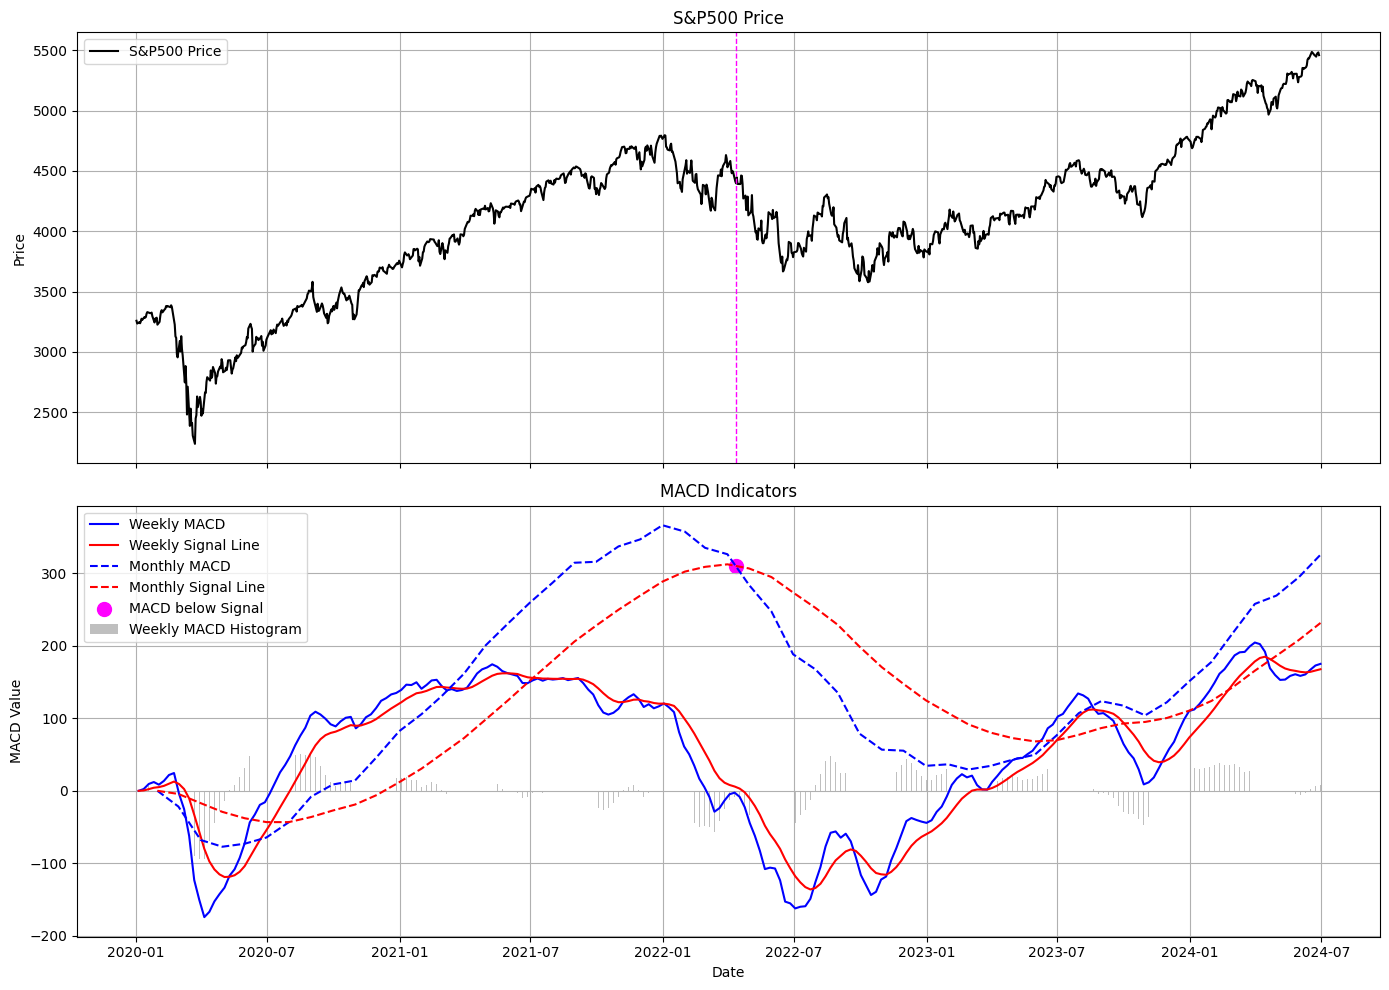

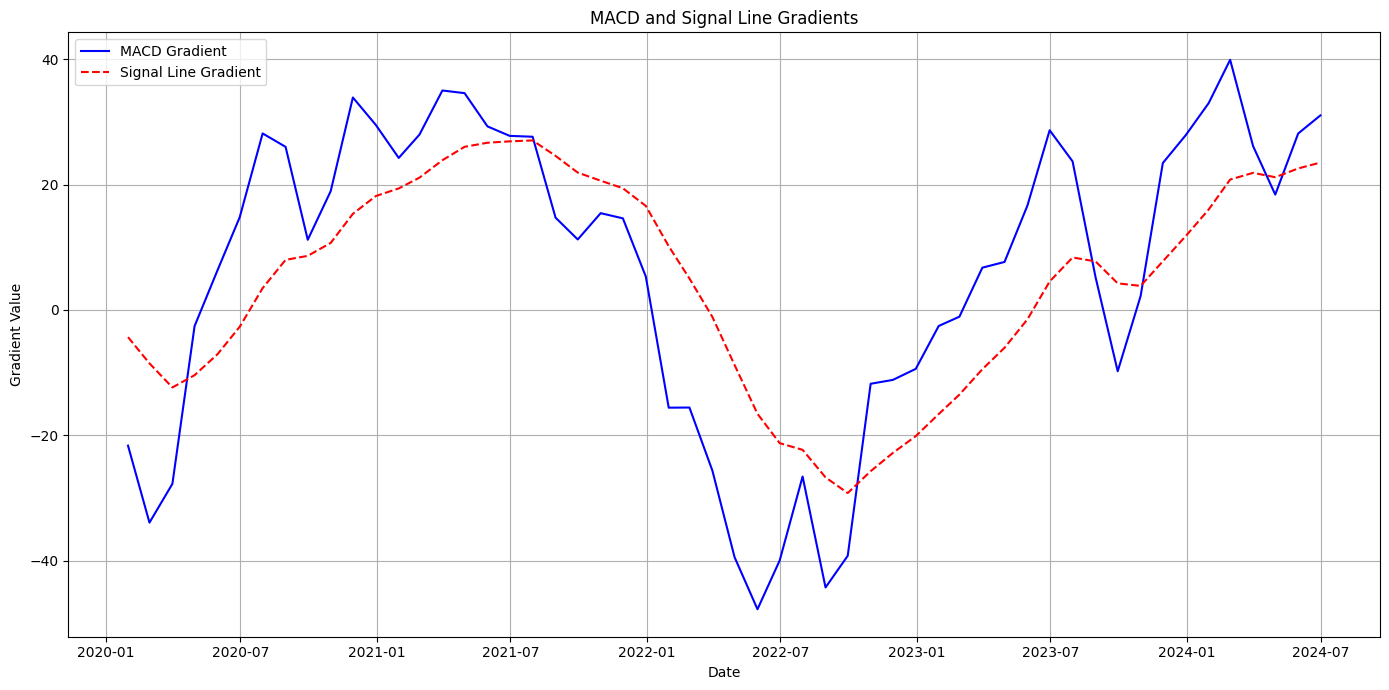

In [81]:
if __name__ == "__main__":
    # Fetch historical data for S&P500
    ticker = '^GSPC'
    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start='2020-01-01', end=end_date)
    
    # Resample data to weekly frequency
    df_weekly = df.resample('W').last()
    
    # Resample data to monthly frequency
    df_monthly = df.resample('M').last()
    
    # Calculate MACD for weekly data
    df_weekly = calculate_macd(df_weekly)
    
    # Calculate MACD for monthly data
    df_monthly = calculate_macd(df_monthly)
    
    # Calculate gradients
    df_monthly = calculate_gradients(df_monthly)
    
    # Find exact crossover points
    crossovers = find_exact_crossover_points(df_monthly)
    
    # Plot price and MACD indicators
    plot_price_and_macd(df, df_weekly, df_monthly, crossovers)
    
    # Plot gradients
    plot_gradients(df_monthly)